
---
# Load needed libraries and functions

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../load_magic/storage.py
%run ../load_magic/environment.py
from IPython.display import set_matplotlib_formats
from scipy.stats import entropy
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gensim
import inspect
import matplotlib.pyplot as plt
import numpy as np
import time

set_matplotlib_formats('retina')
notebook_path = get_notebook_path()
s = Storage()
if s.pickle_exists('BASIC_TAGS_DICT'):
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
else:
    BASIC_TAGS_DICT = {}
    s.store_objects(BASIC_TAGS_DICT=BASIC_TAGS_DICT)

In [3]:

print(notebook_path)
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
print([fn for fn in dir() if not fn.startswith('_')])

C:\Users\dev\Documents\Repositories\job-hunting\ipynb\Indeed Header Classifier Scores.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.pickle_exists', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
['AdaBoostClassifier', 'BASIC_TAGS_DICT', 'BaggingClassifier', 'Config', 'CountVectorizer', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'In', 'LogisticRegression', 'Out', 'RandomForestClassifier', 'SVC', 'StackingClassifier', 'Storage', 'TfidfTransformer', 'VotingClassifier', 'csv', 'entropy', 'exit', 'gensim', 'get_all_files_containing', 'get_classifier', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_importances', 'get_input_sample', 'get_ipython', 'get_module_version', 'get_modules_dataframe', 'get_notebook_path', 'get_struct_name', 'inspect', 'ipykernel', 'json', 'jupyter_config_dir', 'notebook

In [4]:

len(BASIC_TAGS_DICT.keys())

216


---
# Needed extra functions

In [5]:

import re

SCANNER_REGEX = re.compile(r'</?\w+|\w+[#\+]*|:|\.')
def regex_tokenizer(corpus):
    
    return [match.group() for match in re.finditer(SCANNER_REGEX, corpus)]


---
# Training

In [6]:

# Rebuild the datframe from the dictionary
rows_list = [{'navigable_parent': navigable_parent,
              'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
basic_tags_df = pd.DataFrame(rows_list, columns=['navigable_parent', 'is_header'])
s.store_objects(basic_tags_df=basic_tags_df)

# Re-transform the bag-of-words and tf-idf from the new manual scores
sents_list = basic_tags_df.navigable_parent.tolist()
if len(sents_list):
    
    # Bag-of-words
    cv = CountVectorizer(**{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'lowercase': False, 'max_df': 1.0,
                            'max_features': None, 'min_df': 0.0, 'ngram_range': (1, 5), 'stop_words': None, 'strip_accents': 'ascii',
                            'tokenizer': regex_tokenizer})
    bow_matrix = cv.fit_transform(sents_list)
    s.store_objects(bq_cv_vocab=cv.vocabulary_)
    
    # Tf-idf, must get from BOW first
    tt = TfidfTransformer(**{'norm': 'l1', 'smooth_idf': True, 'sublinear_tf': False, 'use_idf': True})
    tfidf_matrix = tt.fit_transform(bow_matrix)
    s.store_objects(bq_tt=tt)
    
    # Re-train the classifier
    X = tfidf_matrix.toarray()
    y = basic_tags_df.is_header.to_numpy()
    basic_tags_clf = LogisticRegression(**{'C': 375.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'max_iter': 400,
                                           'penalty': 'l1', 'solver': 'liblinear', 'tol': 7e-07})
    basic_tags_clf.fit(X, y)
    s.store_objects(basic_tags_clf=basic_tags_clf)
    
    # Re-calibrate the inference engine
    bq_cv_vocab = s.load_object('bq_cv_vocab')
    bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
    bq_cv._validate_vocabulary()
    bq_tt = s.load_object('bq_tt')
    def predict_percent_fit(quals_list):
        y_predict_proba = np.array([])
        if len(quals_list):
            X_test = bq_tt.transform(bq_cv.transform(quals_list)).toarray()
            y_predict_proba = basic_tags_clf.predict_proba(X_test)

        return y_predict_proba
print('Retraining complete')

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\bq_cv_vocab.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\bq_tt.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_clf.pickle
Retraining complete



---
# Rescore the quals dataframe

In [7]:

# Get the training data and models
if len(sents_list):
    X = tfidf_matrix.toarray()
    y = basic_tags_df.is_header.to_numpy()
    estimators_list = [
                       # done in 3.035s
                       # Best score: 0.722
                       AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=5, random_state=None),
                       
                       # done in 332.301s
                       # Best score: 0.814
                       BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=0.5, max_samples=0.75,
                                         n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                       
                       # done in 221.215s
                       # Best score: 0.683
                       ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=100,
                                            max_features='sqrt', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,
                                            min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                            n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                       
                       # done in xxxx
                       # Best score: xxxxx
                       GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance',
                                                  max_depth=3,
                                                  max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                                  min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                                  n_iter_no_change=None, presort='deprecated', random_state=None, subsample=1.0, tol=0.0001,
                                                  validation_fraction=0.1, verbose=0, warm_start=False),
                       
                       # done in xxxx
                       # Best score: xxxxx
                       RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None,
                                              min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100,
                                              n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False),
                       
                       # done in xxxx
                       # Best score: xxxxx
                       LogisticRegression(**{'C': 375.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'max_iter': 400,
                                             'penalty': 'l1', 'solver': 'liblinear', 'tol': 7e-07}),
                       
                       # done in xxxx
                       # Best score: xxxxx
                       SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
                           verbose=False)]

    # Fit the data and add the duration and fitted models to lists
    fit_estimators_list = []
    training_durations_list = []
    for clf in estimators_list:
        start_time = time.time()
        fit_estimators_list.append(clf.fit(X, y))
        stop_time = time.time()
        training_durations_list.append(stop_time - start_time)
    s.store_objects(estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle


In [8]:

from gensim.corpora.dictionary import Dictionary

fit_estimators_list = s.load_object('estimators_list')
start_time = time.time()

# Build model with tokenized words
tokenized_sents_list = [regex_tokenizer(sent_str) for sent_str in basic_tags_df.navigable_parent.tolist()]

# Create a corpus from a list of texts
headers_dictionary = Dictionary(tokenized_sents_list)
headers_corpus = [headers_dictionary.doc2bow(tag_str) for tag_str in tokenized_sents_list]

# Train the model on the corpus
lda = gensim.models.ldamodel.LdaModel(corpus=headers_corpus, num_topics=2)
fit_estimators_list.append(lda)

stop_time = time.time()
training_durations_list.append(stop_time - start_time)
s.store_objects(estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Save model as binary file
child_str_model = gensim.models.FastText(tokenized_sents_list)
model_folder = os.path.join(s.data_folder, 'bin')
os.makedirs(name=model_folder, exist_ok=True)
file_path = os.path.join(model_folder, 'child_str_model.bin')
child_str_model.save(file_path)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle


In [9]:

inference_durations_list = []
for clf in fit_estimators_list:
    clf_name = str(type(clf)).split('.')[-1].split("'")[0]
    basic_tags_df[clf_name] = np.nan
    start_time = time.time()
    for row_index, row_series in basic_tags_df.iterrows():
        navigable_parent = row_series.navigable_parent
        if(clf_name == 'LdaModel'):
            X_test = headers_dictionary.doc2bow(regex_tokenizer(navigable_parent))
            
            # Assuming it's the second topic
            y_predict_proba = lda[X_test][0][1]
            
        else:
            X_test = bq_tt.transform(bq_cv.transform([navigable_parent])).toarray()
            y_predict_proba = clf.predict_proba(X_test)[0][1]
        basic_tags_df.loc[row_index, clf_name] = y_predict_proba
    stop_time = time.time()
    inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\inference_durations_list.pickle



### Stacking Classifier

In [10]:

clf = StackingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                         final_estimator=None, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_tags_df = s.load_object('basic_tags_df')
basic_tags_df[clf_name] = np.nan
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
X = bq_tt.transform(bq_cv.transform(basic_tags_df.navigable_parent.tolist())).toarray()
y = basic_tags_df.is_header.to_numpy()
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the quals dataframe
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_tags_df.iterrows():
    navigable_parent = row_series.navigable_parent
    X_test = bq_tt.transform(bq_cv.transform([navigable_parent])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_tags_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\fit_estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\inference_durations_list.pickle



### Voting Classifier

In [11]:

clf = VotingClassifier(estimators=[(str(type(e)).split('.')[-1].split("'")[0], e) for e in estimators_list],
                       voting='soft', weights=None, n_jobs=None, flatten_transform=True)
clf_name = str(type(clf)).split('.')[-1].split("'")[0]
basic_tags_df[clf_name] = np.nan
fit_estimators_list = s.load_object('fit_estimators_list')
start_time = time.time()
fit_estimators_list.append(clf.fit(X, y))
stop_time = time.time()
training_durations_list = s.load_object('training_durations_list')
training_durations_list.append(stop_time - start_time)
s.store_objects(fit_estimators_list=fit_estimators_list, training_durations_list=training_durations_list)

# Re-score the quals dataframe
bq_cv_vocab = s.load_object('bq_cv_vocab')
bq_cv = CountVectorizer(vocabulary=bq_cv_vocab)
bq_cv._validate_vocabulary()
bq_tt = s.load_object('bq_tt')
inference_durations_list = s.load_object('inference_durations_list')
start_time = time.time()
for row_index, row_series in basic_tags_df.iterrows():
    navigable_parent = row_series.navigable_parent
    X_test = bq_tt.transform(bq_cv.transform([navigable_parent])).toarray()
    y_predict_proba = clf.predict_proba(X_test)[0][1]
    basic_tags_df.loc[row_index, clf_name] = y_predict_proba
stop_time = time.time()
inference_durations_list.append(stop_time - start_time)
s.store_objects(basic_tags_df=basic_tags_df, inference_durations_list=inference_durations_list)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\fit_estimators_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\training_durations_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\basic_tags_df.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\inference_durations_list.pickle


In [12]:

try:
    basic_tags_df = s.load_object('basic_tags_df')
except:
    columns_list = ['navigable_parent', 'is_header', 'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier',
                    'GradientBoostingClassifier', 'RandomForestClassifier', 'LogisticRegression', 'SVC', 'LdaModel', 'StackingClassifier',
                    'VotingClassifier']
    basic_tags_df = pd.DataFrame([], columns=columns_list)
    s.store_objects(basic_tags_df=basic_tags_df)
print(basic_tags_df.columns.tolist())
basic_tags_df.sample(5).T

['navigable_parent', 'is_header', 'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'LogisticRegression', 'SVC', 'LdaModel', 'StackingClassifier', 'VotingClassifier']


,100,31,111,48,188
navigable_parent,<b>Advance your career at Liberty</b>,<b>Location</b>,The,<li>Tuition reimbursement</li>,<li>Strong proficiency in advanced data scienc...
is_header,False,True,False,False,False
AdaBoostClassifier,0.179072,0.179072,0.179072,0.179072,0.179072
BaggingClassifier,0,0,0,0,0
ExtraTreesClassifier,0,0,0,0,0
GradientBoostingClassifier,0.000867445,0.000867445,0.000867445,0.000867445,0.000867445
RandomForestClassifier,0,0,0,0,0
LogisticRegression,0.00330539,0.00330539,0.00330539,0.00330539,0.00330539
SVC,0.191401,0.248681,0.248733,0.248666,0.0274535
LdaModel,0.925135,0.807484,0.277391,0.889253,0.959836


In [13]:

metrics_list = ['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score',
                'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score',
                'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score',
                'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']
exec('from sklearn.metrics import {}'.format(', '.join(metrics_list)))
fit_estimators_list = s.load_object('fit_estimators_list')
clf_name_list = [str(type(clf)).split('.')[-1].split("'")[0] for clf in fit_estimators_list]
basic_tags_df = s.load_object('basic_tags_df')
y_true = basic_tags_df.is_header.tolist()
fit_match_series = (basic_tags_df.is_header == True)
yes_list = basic_tags_df[fit_match_series].is_header.tolist()
no_list = basic_tags_df[~fit_match_series].is_header.tolist()
columns_list = ['clf_name', 'training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy',
                'relative_yes_entropy'] + metrics_list
rows_list = []
training_durations_list = s.load_object('training_durations_list')
inference_durations_list = s.load_object('inference_durations_list')
for column_name, training_duration, inference_duration in zip(clf_name_list, training_durations_list, inference_durations_list):
    yes_series = basic_tags_df[fit_match_series][column_name]
    upper_bound = yes_series.min()
    no_series = basic_tags_df[~fit_match_series][column_name]
    lower_bound = no_series.max()
    y_pred = []
    for p in basic_tags_df[column_name]:
        if p > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    row_dict = {}
    row_dict['clf_name'] = column_name
    row_dict['training_duration'] = training_duration
    row_dict['inference_duration'] = inference_duration
    row_dict['boundary_diff'] = upper_bound-lower_bound
    row_dict['clf_yes_entropy'] = entropy(pk=yes_series.tolist())
    row_dict['relative_yes_entropy'] = entropy(pk=yes_list, qk=yes_series.tolist())
    for metric_str in metrics_list:
        try:
            row_dict[metric_str] = eval('{}(y_true, basic_tags_df[column_name].tolist())'.format(metric_str))
        except Exception as e1:
            try:
                row_dict[metric_str] = eval('{}(y_true, y_pred)'.format(metric_str))
            except Exception as e2:
                row_dict[metric_str] = np.nan
    rows_list.append(row_dict)
entropy_df = pd.DataFrame(rows_list, columns=columns_list).dropna(axis='columns', how='all')
entropy_df.set_index('clf_name', drop=True, inplace=True)
s.store_objects(entropy_df=entropy_df)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\entropy_df.pickle


In [14]:

description_dict = {name: fn.__doc__.strip().split('\n')[0] for name, fn in inspect.getmembers(sys.modules[__name__],
                                                                                               inspect.isfunction) if name in metrics_list}
try:
    entropy_df = s.load_object('entropy_df')
except:
    columns_list = ['training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy', 'accuracy_score',
                    'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score',
                    'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score',
                    'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score',
                    'recall_score', 'roc_auc_score', 'v_measure_score']
    entropy_df = pd.DataFrame([], columns=columns_list)
    s.store_objects(entropy_df=entropy_df)
for name, cls in inspect.getmembers(sys.modules[__name__], inspect.isclass):
    if name in entropy_df.index:
        description_dict[name] = cls.__doc__.strip().split('\n')[0]
s.store_objects(metrics_list=metrics_list, description_dict=description_dict)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\metrics_list.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\description_dict.pickle


In [15]:

print(entropy_df.columns.tolist())
metrics_list

['training_duration', 'inference_duration', 'boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']


['accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision_score', 'balanced_accuracy_score', 'cohen_kappa_score', 'completeness_score', 'explained_variance_score', 'f1_score', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard_score', 'mutual_info_score', 'normalized_mutual_info_score', 'precision_score', 'r2_score', 'recall_score', 'roc_auc_score', 'v_measure_score']

In [16]:

columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
entropy_df[columns_list].sort_values('balanced_accuracy_score', ascending=False)

,training_duration,inference_duration,balanced_accuracy_score,r2_score
clf_name,,,,
VotingClassifier,25.215879,15.580018,0.812500,0.693455
AdaBoostClassifier,6.968003,7.423954,0.500000,-0.037407
BaggingClassifier,1.399229,2.093805,0.500000,-0.116094
ExtraTreesClassifier,2.435645,6.787693,0.500000,-0.087364
GradientBoostingClassifier,22.265875,1.182582,0.500000,-0.122788
RandomForestClassifier,1.081193,7.082670,0.500000,-0.098342
LogisticRegression,2.281480,0.656356,0.500000,-0.117417
SVC,5.818326,2.171171,0.500000,0.122308
StackingClassifier,133.141551,11.506133,0.500000,0.444979


In [17]:

fit_estimators_list = s.load_object('fit_estimators_list')
fit_estimators_dict = {str(type(clf)).split('.')[-1].split("'")[0]: clf for clf in fit_estimators_list}
s.store_objects(fit_estimators_dict=fit_estimators_dict)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\fit_estimators_dict.pickle



----

r2_score: R^2 (coefficient of determination) regression score function.
explained_variance_score: Explained variance regression score function


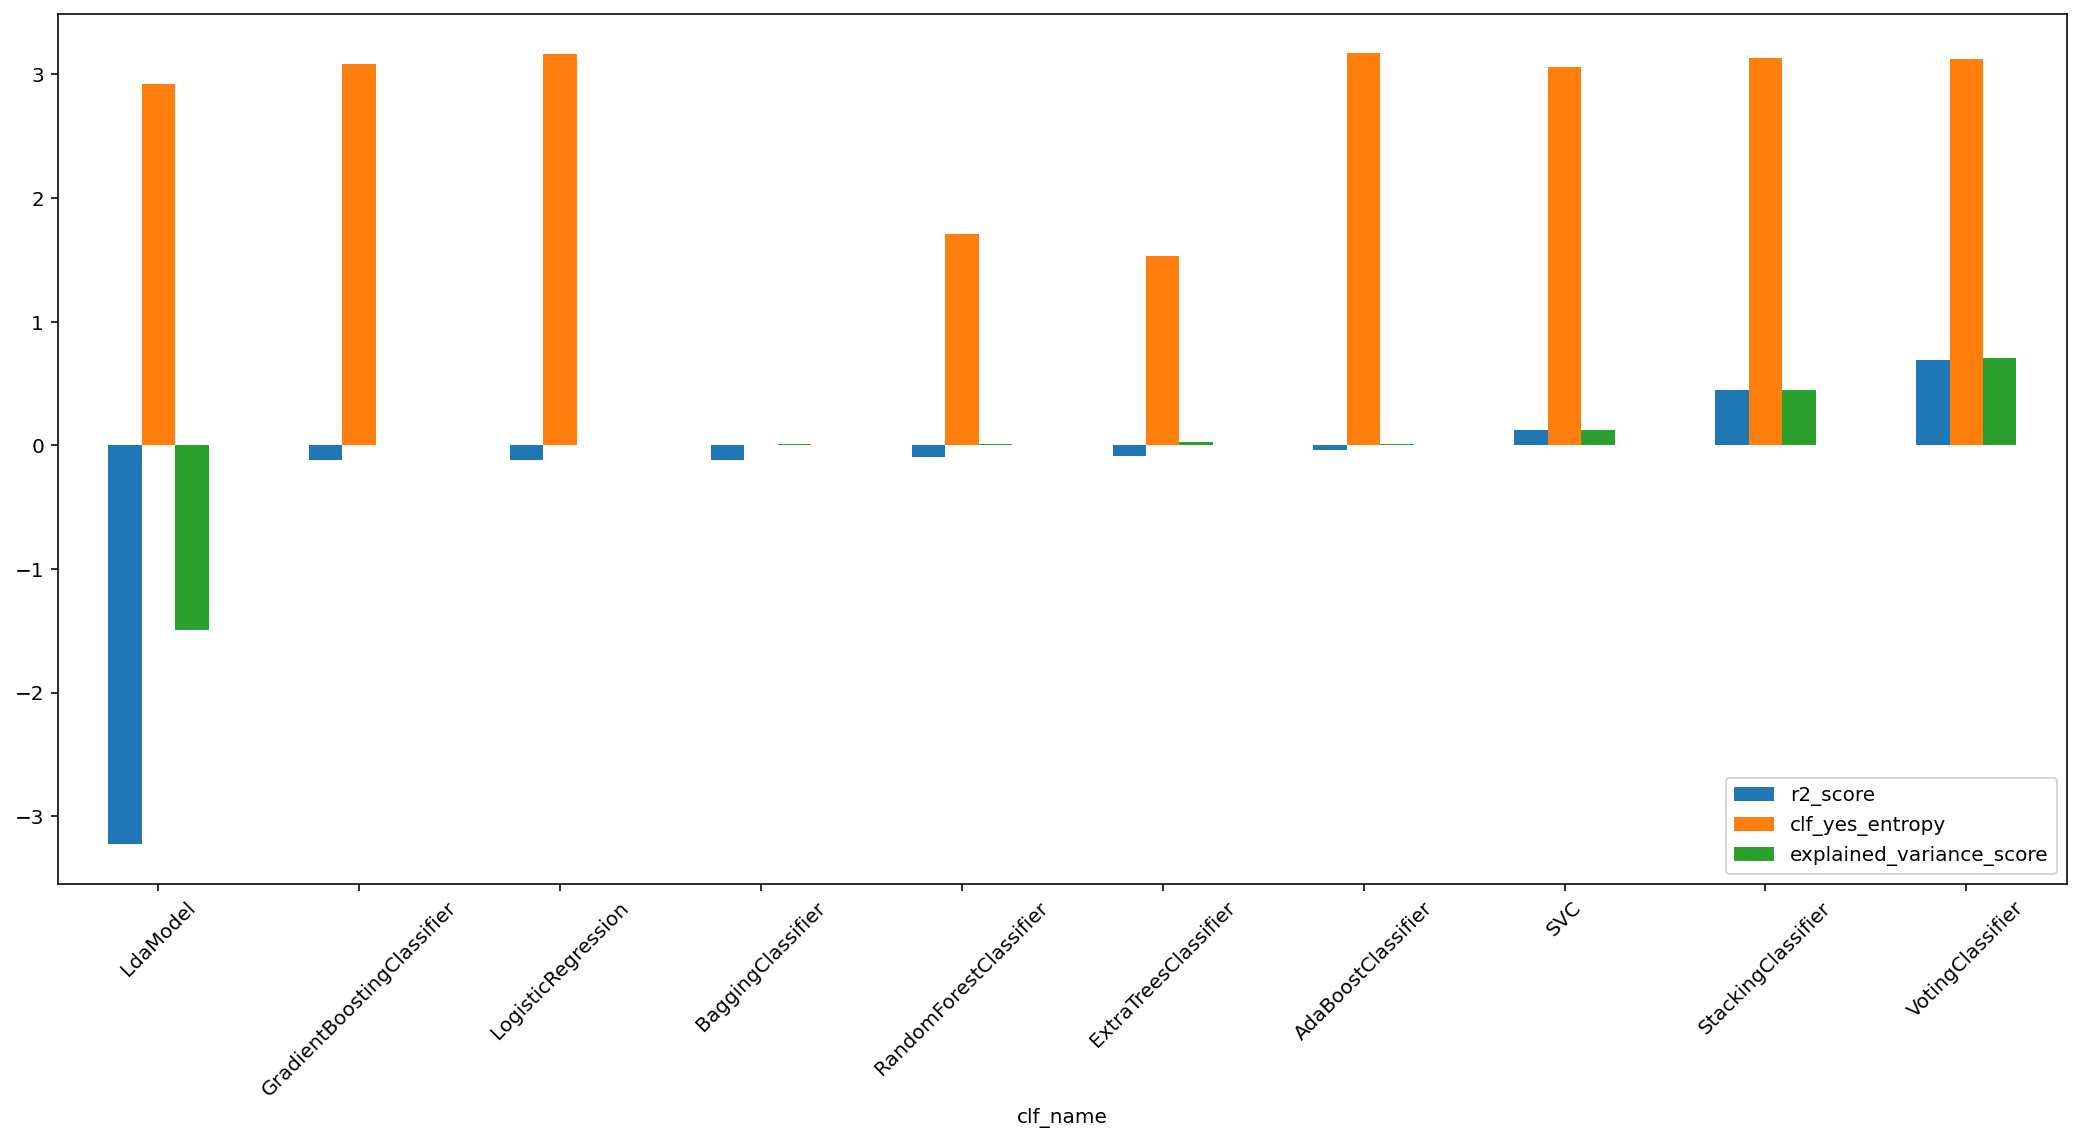

In [20]:

entropy_df = s.load_object('entropy_df')
if entropy_df.shape[0]:
    metrics_list = s.load_object('metrics_list')
    custom_metrics_list = ['boundary_diff', 'clf_yes_entropy', 'relative_yes_entropy']
    columns_list = metrics_list + custom_metrics_list
    columns_list = [cn for cn, s in sorted([(cn, entropy_df[cn].std()) for cn in columns_list], key=lambda x: x[1], reverse=True)][:3]
    description_dict = s.load_object('description_dict')
    for metric in columns_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    df = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list]
    AxesSubplot_obj = df.plot.bar(rot=45, figsize=(18, 8))

In [21]:

from IPython.display import display

row_dict = {}
for column_name in df.columns:
    row_dict[column_name] = df[column_name].std()
display(df.append(pd.DataFrame([row_dict], index=['Standard Deviation'])))

,r2_score,clf_yes_entropy,explained_variance_score
LdaModel,-3.226965,2.925992,-1.497414
GradientBoostingClassifier,-0.122788,3.085117,0.000235
LogisticRegression,-0.117417,3.167493,0.000229
BaggingClassifier,-0.116094,0.000000,0.007867
RandomForestClassifier,-0.098342,1.705586,0.012794
ExtraTreesClassifier,-0.087364,1.527908,0.028939
AdaBoostClassifier,-0.037407,3.169500,0.010202
SVC,0.122308,3.056886,0.122408
StackingClassifier,0.444979,3.137036,0.446769
VotingClassifier,0.693455,3.126404,0.708199


balanced_accuracy_score: Compute the balanced accuracy
r2_score: R^2 (coefficient of determination) regression score function.


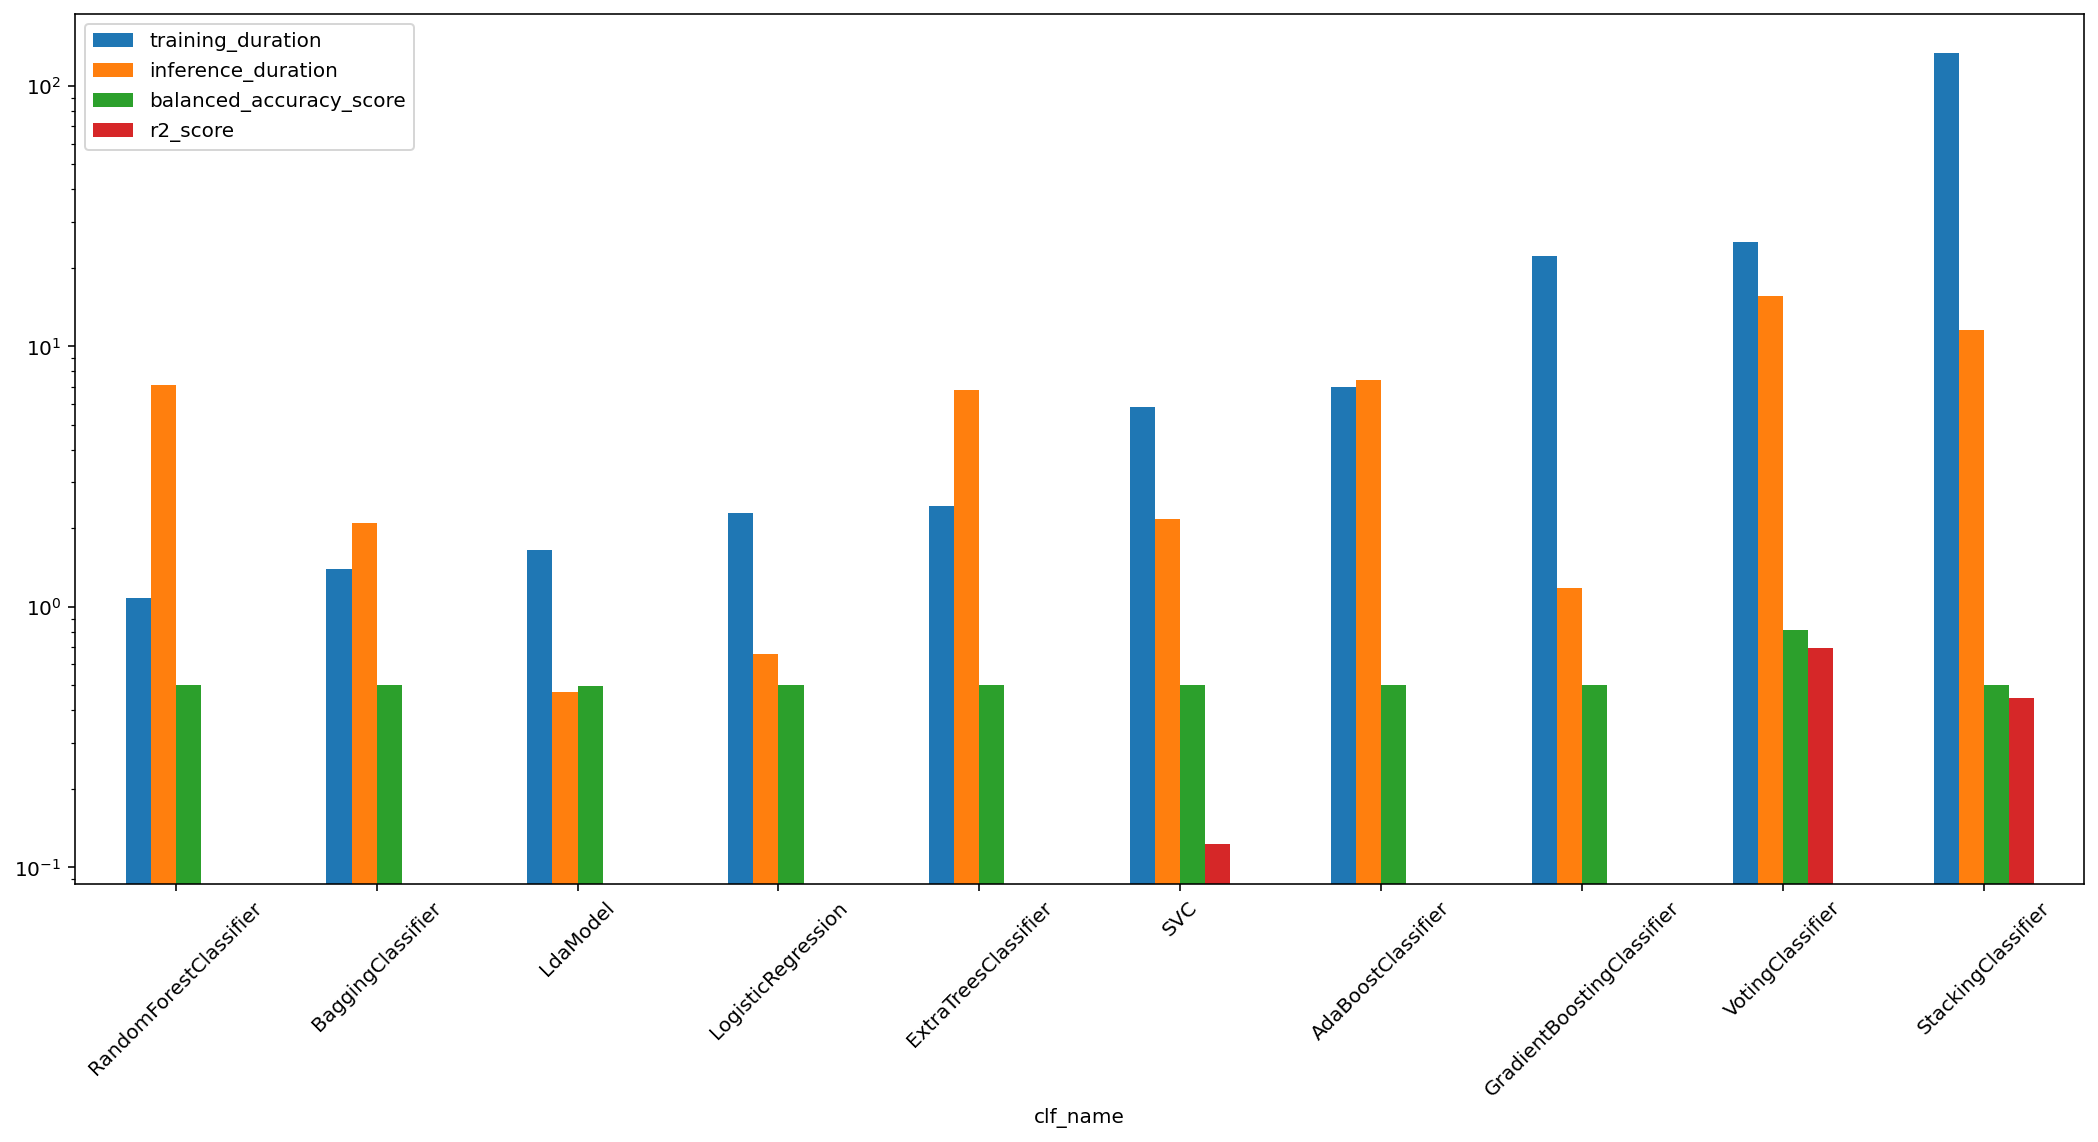

In [22]:

if entropy_df.shape[0]:
    description_dict = s.load_object('description_dict')
    columns_list = ['training_duration', 'inference_duration', 'balanced_accuracy_score', 'r2_score']
    for metric in columns_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    entropy_df = s.load_object('entropy_df')
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_yscale('log')
    AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.bar(rot=45, ax=ax)

accuracy_score: Accuracy classification score.
balanced_accuracy_score: Compute the balanced accuracy


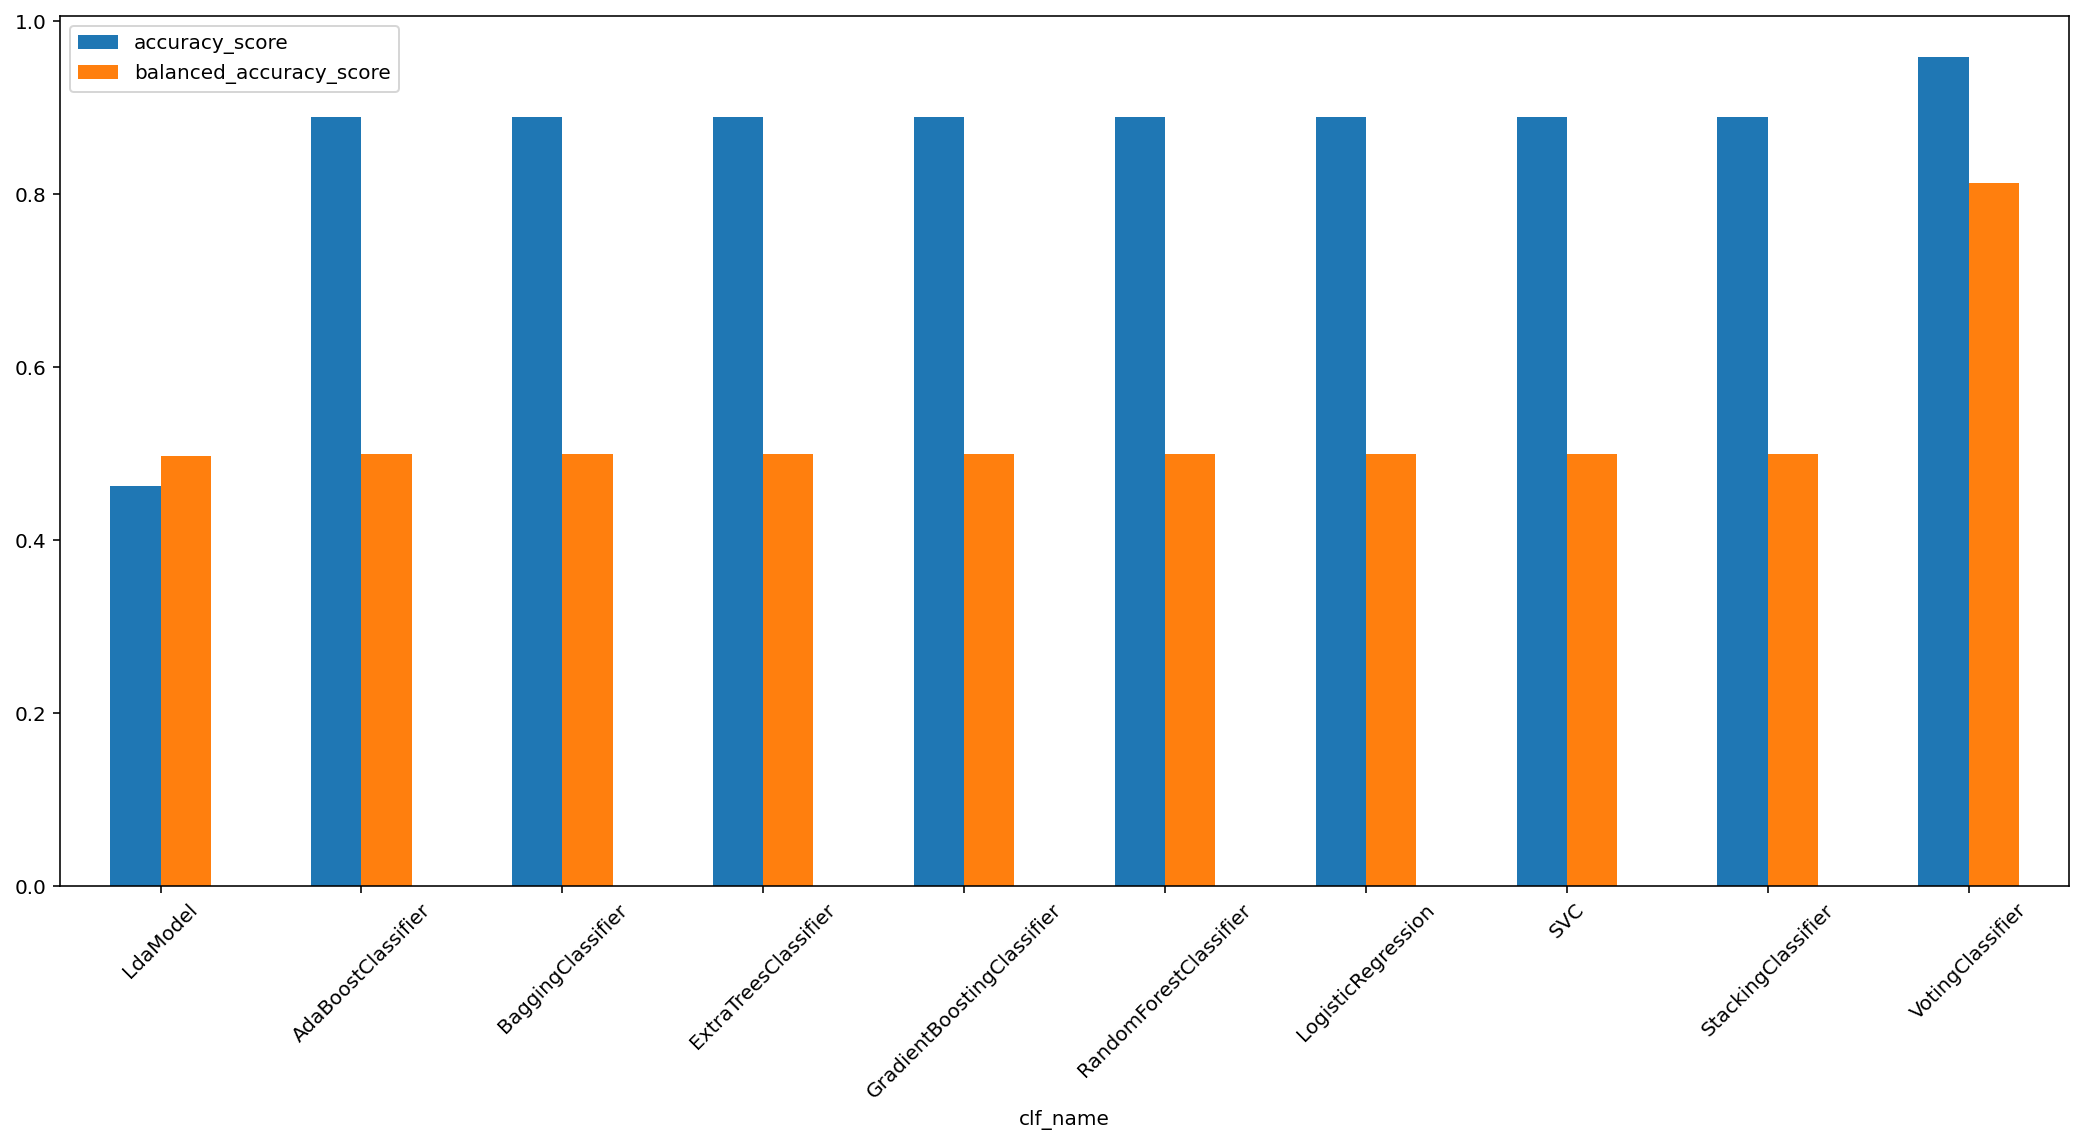

In [23]:

if entropy_df.shape[0]:
    metrics_list = s.load_object('metrics_list')
    columns_list = [cn for cn in metrics_list if 'accur' in cn.lower()]
    for metric in columns_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    AxesSubplot_obj = entropy_df.sort_values(columns_list[0], ascending=True)[columns_list].plot.bar(rot=45, figsize=(18, 8))

In [24]:

entropy_df.sort_values('boundary_diff', ascending=False)[custom_metrics_list]

,boundary_diff,clf_yes_entropy,relative_yes_entropy
clf_name,,,
AdaBoostClassifier,0.000000,3.169500,0.007262
BaggingClassifier,0.000000,0.000000,inf
LogisticRegression,0.000000,3.167493,0.008835
GradientBoostingClassifier,-0.000136,3.085117,0.063455
ExtraTreesClassifier,-0.060000,1.527908,inf
RandomForestClassifier,-0.070000,1.705586,inf
StackingClassifier,-0.080025,3.137036,0.044938
VotingClassifier,-0.185999,3.126404,0.058325
SVC,-0.242185,3.056886,0.325085


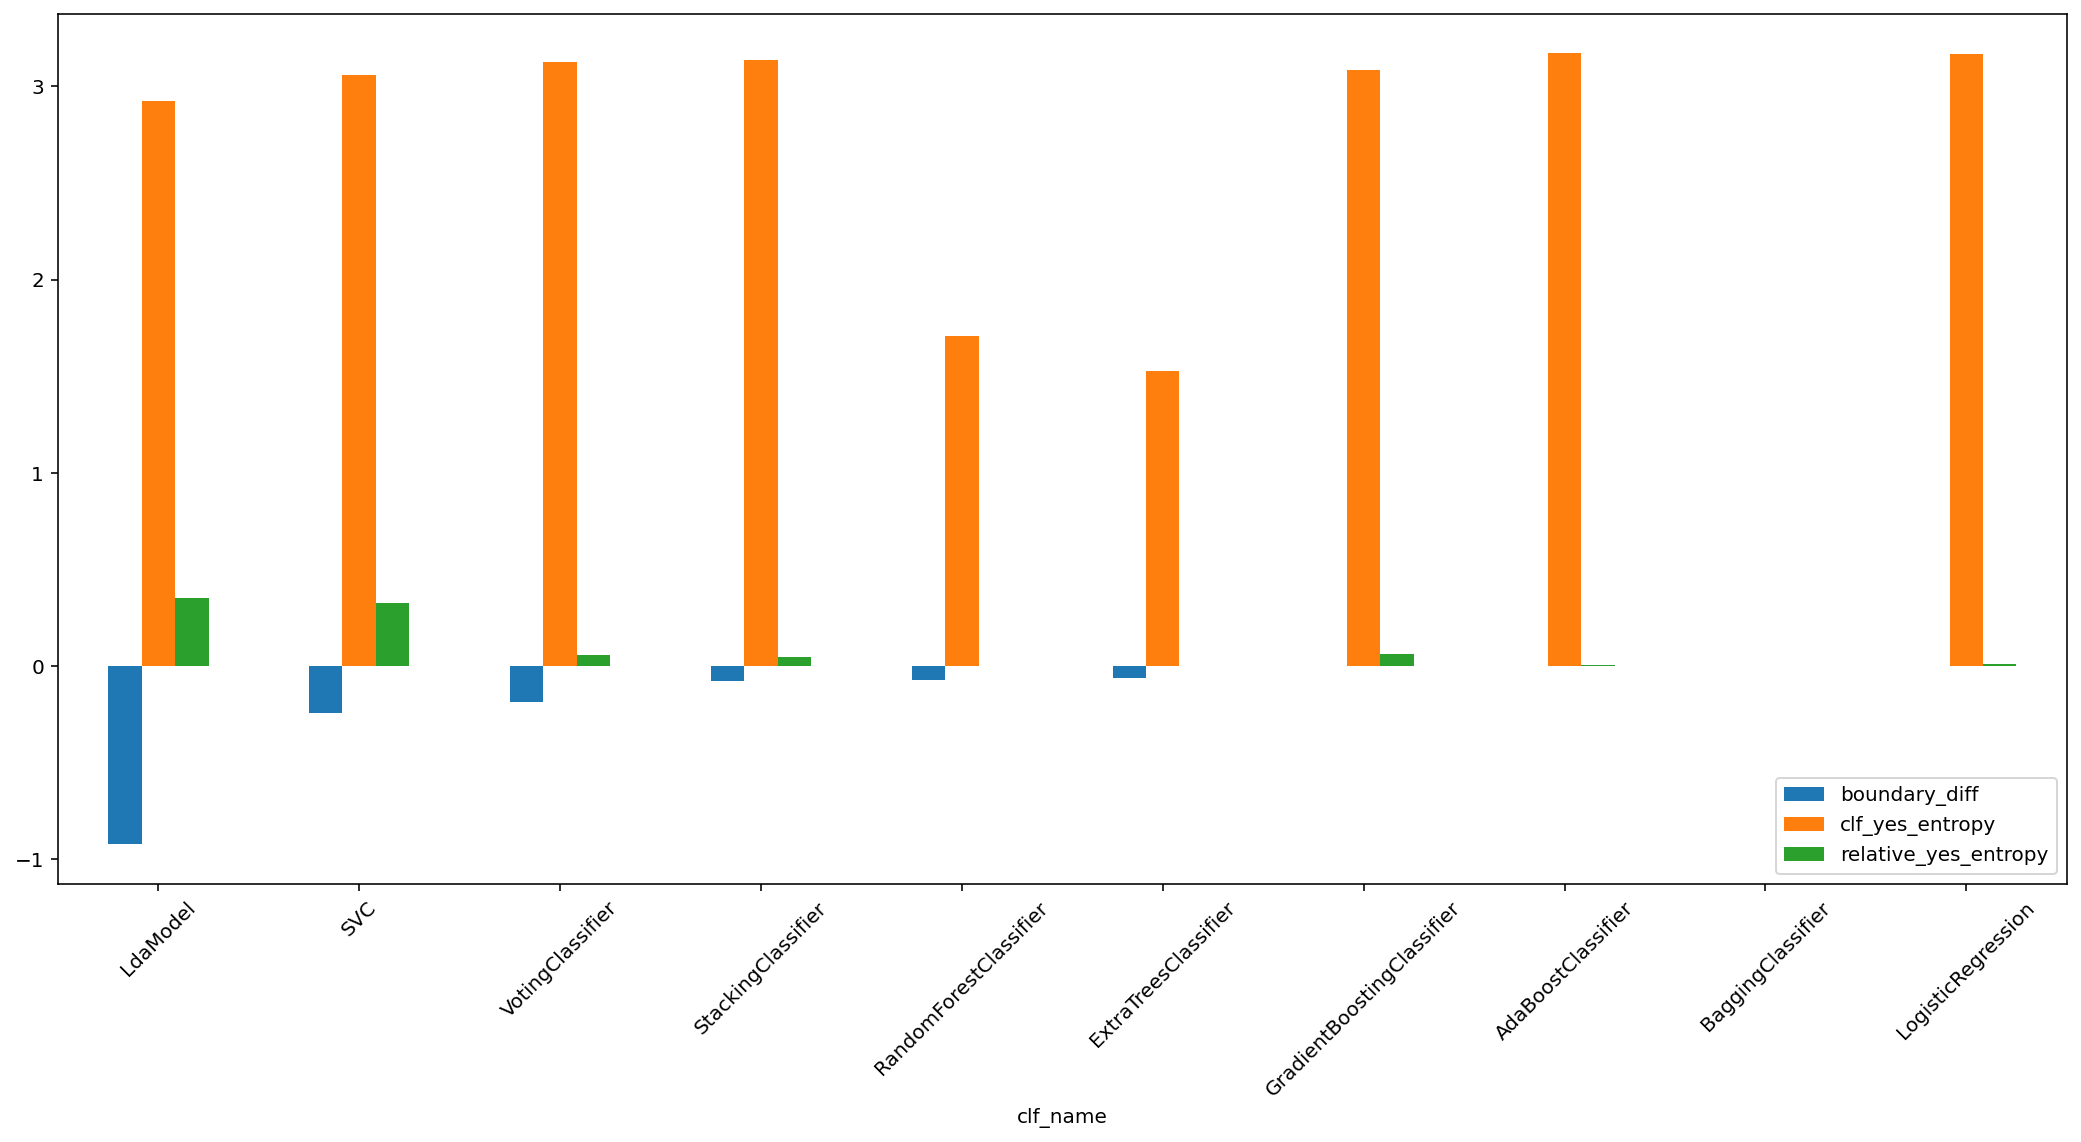

In [25]:

if entropy_df.shape[0]:
    for metric in custom_metrics_list:
        if metric in description_dict:
            print('{}: {}'.format(metric, description_dict[metric]))
    AxesSubplot_obj = entropy_df.sort_values('boundary_diff', ascending=True)[custom_metrics_list].plot.bar(rot=45, figsize=(18, 8))

average_precision_score: Compute average precision (AP) from prediction scores
precision_score: Compute the precision
recall_score: Compute the recall


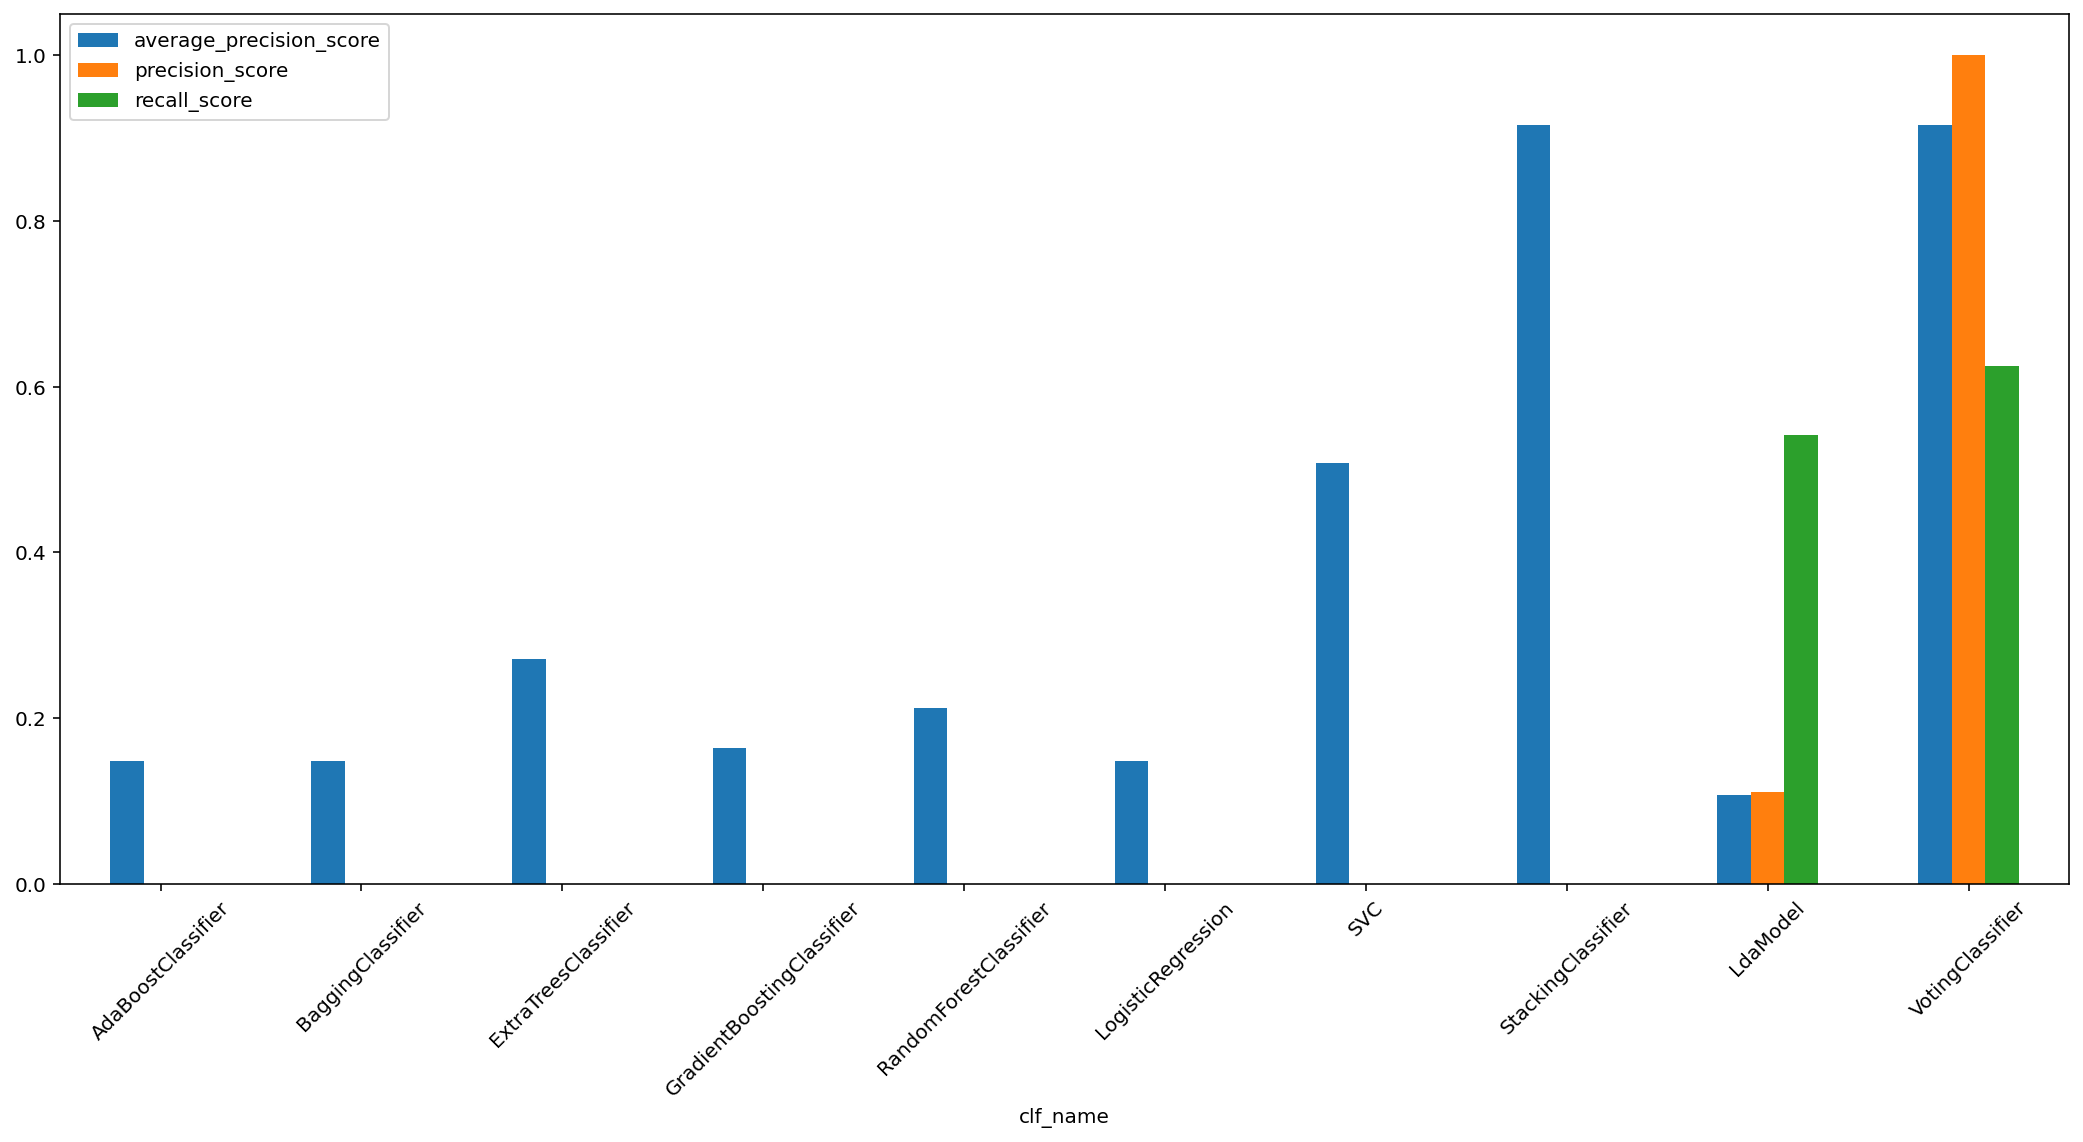

In [26]:

entropy_df = s.load_object('entropy_df')
if entropy_df.shape[0]:
    columns_list = ['average_precision_score', 'precision_score', 'recall_score']
    description_dict = s.load_object('description_dict')
    for metric in columns_list:
        print('{}: {}'.format(metric, description_dict[metric]))
    AxesSubplot_obj = entropy_df.sort_values('precision_score', ascending=True)[columns_list].plot.bar(rot=45, figsize=(18, 8))

In [27]:

columns_list = ['average_precision_score', 'precision_score', 'recall_score']
extended_columns_list = ['training_duration', 'inference_duration'] + columns_list
entropy_df.sort_values('precision_score', ascending=True)[extended_columns_list]

,training_duration,inference_duration,average_precision_score,precision_score,recall_score
clf_name,,,,,
AdaBoostClassifier,6.968003,7.423954,0.148148,0.000000,0.000000
BaggingClassifier,1.399229,2.093805,0.148148,0.000000,0.000000
ExtraTreesClassifier,2.435645,6.787693,0.270833,0.000000,0.000000
GradientBoostingClassifier,22.265875,1.182582,0.164352,0.000000,0.000000
RandomForestClassifier,1.081193,7.082670,0.211823,0.000000,0.000000
LogisticRegression,2.281480,0.656356,0.148148,0.000000,0.000000
SVC,5.818326,2.171171,0.507611,0.000000,0.000000
StackingClassifier,133.141551,11.506133,0.916319,0.000000,0.000000
LdaModel,1.644579,0.468712,0.106860,0.110169,0.541667



----

In [ ]:

[(str(type(e)).split('.')[-1].split("'")[0], e) for e in fit_estimators_list]

In [18]:

idx = 'LdaModel'
mask_series = (entropy_df.index == idx)
entropy_df[mask_series].T.to_dict()[idx]

{'training_duration': 1.0965571403503418, 'inference_duration': 0.5192391872406006, 'boundary_diff': 0.0, 'clf_yes_entropy': nan, 'relative_yes_entropy': nan, 'accuracy_score': 0.8888888888888888, 'adjusted_mutual_info_score': 3.1826859909265223e-16, 'adjusted_rand_score': 0.0, 'average_precision_score': 0.1111111111111111, 'balanced_accuracy_score': 0.5, 'cohen_kappa_score': 0.0, 'completeness_score': 1.0, 'explained_variance_score': 0.0, 'f1_score': 0.0, 'fowlkes_mallows_score': 0.8952934645114412, 'homogeneity_score': 1.5913429954632612e-16, 'jaccard_score': 0.0, 'mutual_info_score': 5.551115123125783e-17, 'normalized_mutual_info_score': 3.1826859909265223e-16, 'precision_score': 0.0, 'r2_score': -0.12499999999999978, 'recall_score': 0.0, 'roc_auc_score': 0.5, 'v_measure_score': 3.182685990926522e-16}

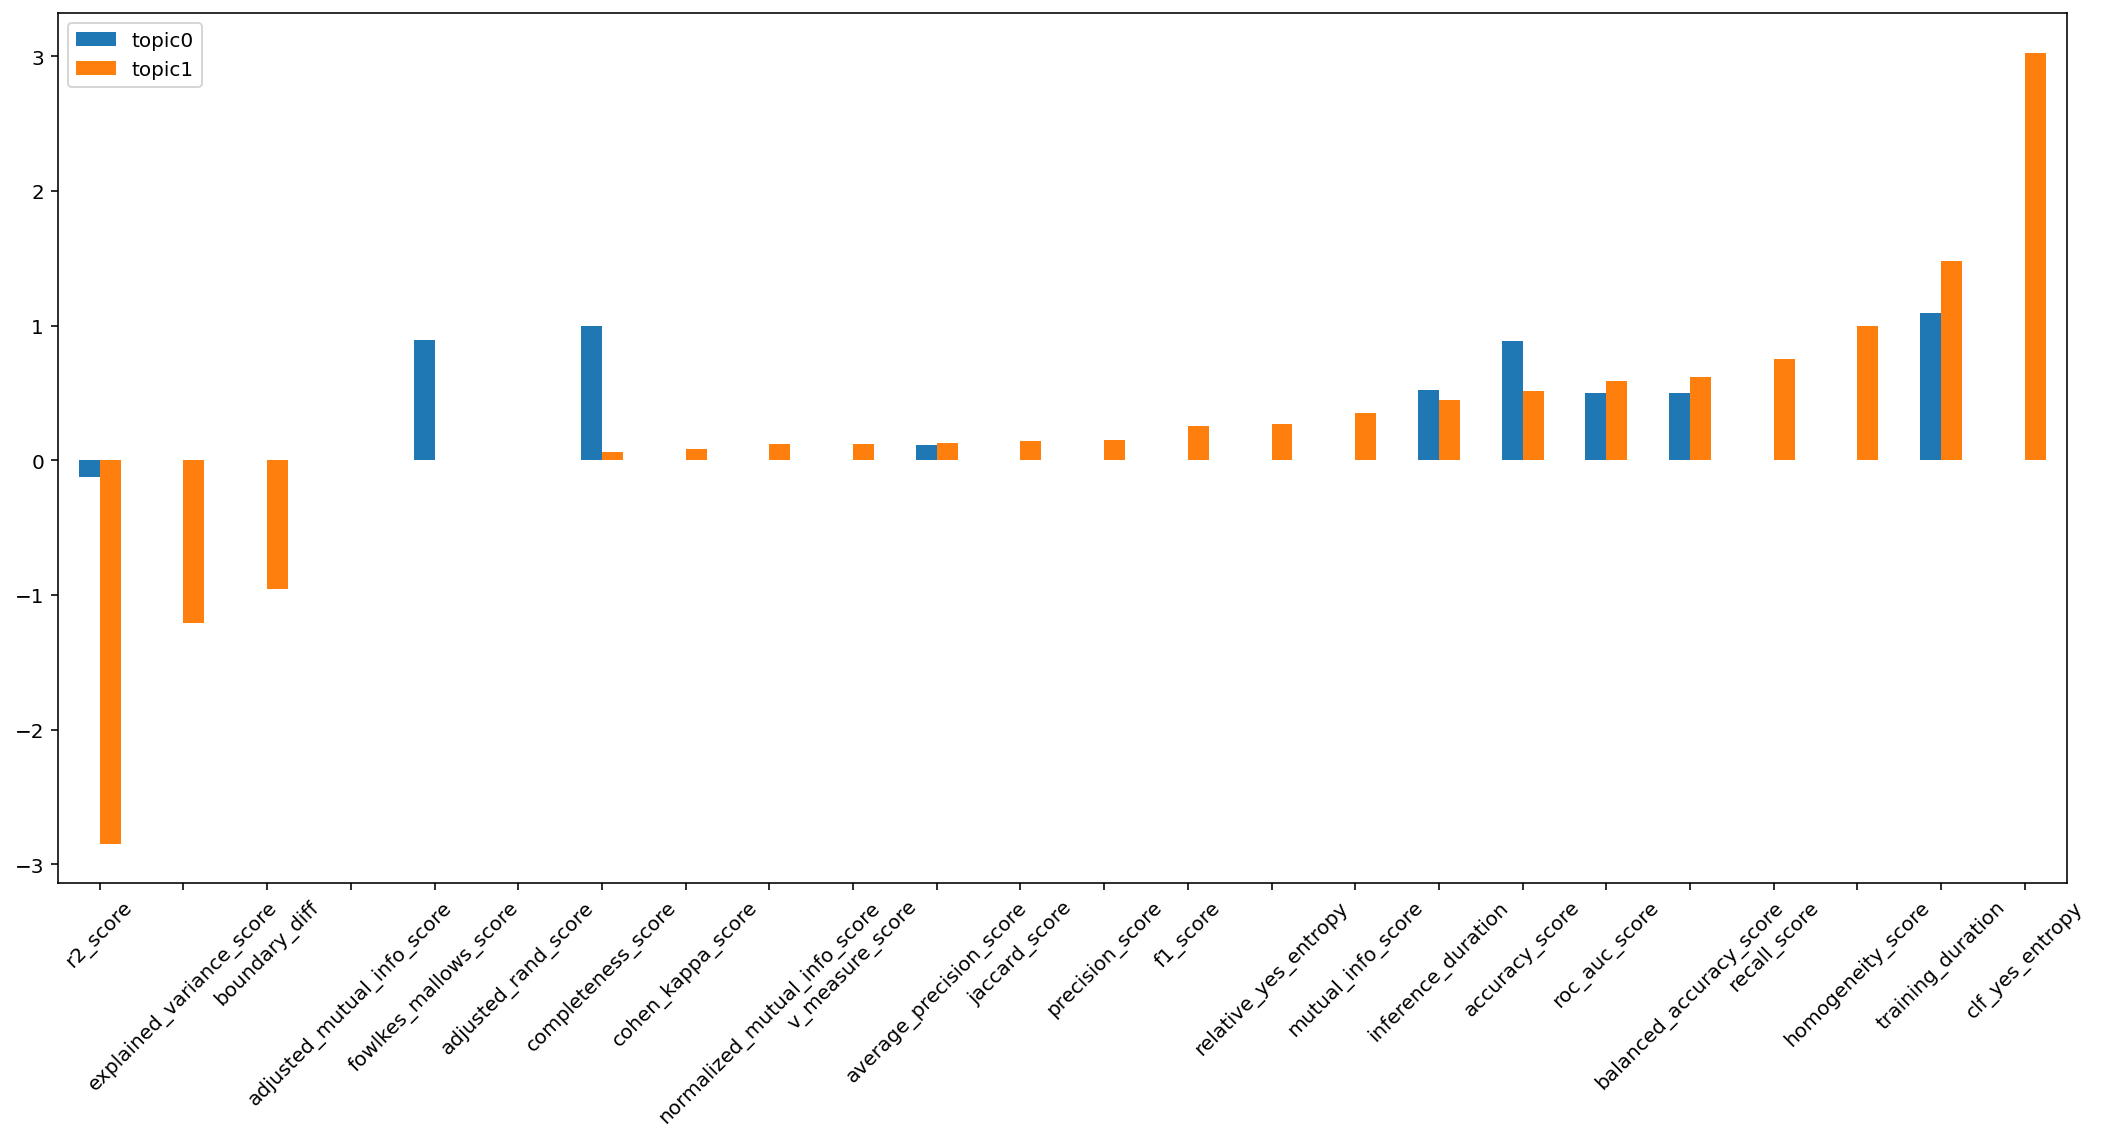

In [25]:

rows_list = [{
    'training_duration': 1.0965571403503418,
    'inference_duration': 0.5192391872406006,
    'boundary_diff': 0.0,
    'clf_yes_entropy': np.nan,
    'relative_yes_entropy': np.nan,
    'accuracy_score': 0.8888888888888888,
    'adjusted_mutual_info_score': 3.1826859909265223e-16,
    'adjusted_rand_score': 0.0,
    'average_precision_score': 0.1111111111111111,
    'balanced_accuracy_score': 0.5,
    'cohen_kappa_score': 0.0,
    'completeness_score': 1.0,
    'explained_variance_score': 0.0,
    'f1_score': 0.0,
    'fowlkes_mallows_score': 0.8952934645114412,
    'homogeneity_score': 1.5913429954632612e-16,
    'jaccard_score': 0.0,
    'mutual_info_score': 5.551115123125783e-17,
    'normalized_mutual_info_score': 3.1826859909265223e-16,
    'precision_score': 0.0,
    'r2_score': -0.12499999999999978,
    'recall_score': 0.0,
    'roc_auc_score': 0.5,
    'v_measure_score': 3.182685990926522e-16
}, {
    'training_duration': 1.4768140316009521,
    'inference_duration': 0.448624849319458,
    'boundary_diff': -0.9573931358754635,
    'clf_yes_entropy': 3.0234928734861413,
    'relative_yes_entropy': 0.2666350946049296,
    'accuracy_score': 0.5138888888888888,
    'adjusted_mutual_info_score': -1.1971497197319733e-14,
    'adjusted_rand_score': 0.0,
    'average_precision_score': 0.12756738529589867,
    'balanced_accuracy_score': 0.6171875,
    'cohen_kappa_score': 0.08695652173913049,
    'completeness_score': 0.06489563319071322,
    'explained_variance_score': -1.2112703385622052,
    'f1_score': 0.25531914893617025,
    'fowlkes_mallows_score': 0.0,
    'homogeneity_score': 1.0000000000000009,
    'jaccard_score': 0.14634146341463414,
    'mutual_info_score': 0.3488320958430325,
    'normalized_mutual_info_score': 0.1218816777307434,
    'precision_score': 0.15384615384615385,
    'r2_score': -2.845917401261067,
    'recall_score': 0.75,
    'roc_auc_score': 0.5859375,
    'v_measure_score': 0.1218816777307434
}]
index = ['topic0', 'topic1']
df = pd.DataFrame(rows_list, index=index).T.sort_values('topic1')
AxesSubplot_obj = df.plot.bar(rot=45, figsize=(18, 8))